In [11]:
import pandas as pd
import numpy as np

# 1. Load data
df = pd.read_excel("Dataset/Nasional_Beras.xlsx", engine='openpyxl')

# 2. Pastikan kolom Tanggal dalam format datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 3. Drop baris tanpa tanggal valid
df = df.dropna(subset=['date'])

# 4. Bersihkan seluruh kolom non-numerik & simbol seperti "-" jadi NaN
for col in df.columns:
    if col != 'date':  # skip kolom tanggal
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^0-9.,-]', '', regex=True).str.replace(',', ''), errors='coerce')

# 5. Jika ada kolom yang 100% NaN → drop saja
df = df.dropna(axis=1, how='all')

# 6. Gabungkan data duplikat tanggal dengan mean
df = df.groupby('date').mean()

# 7. Resample ke harian
df = df.asfreq('D')

# 8. Interpolate
df_interpolated = df.interpolate(method='time')

# 9. Drop deret kosong lebih dari 7 hari
def drop_long_gaps(df, max_gap=7):
    for col in df.columns:
        null_run = df[col].isna().astype(int).groupby((df[col].isna() != df[col].isna().shift()).cumsum()).cumsum()
        long_gap_dates = null_run[null_run > max_gap].index
        if not long_gap_dates.empty:
            print(f"⚠️ Kolom '{col}' memiliki deret kosong > {max_gap} hari pada {len(long_gap_dates)} tanggal. Baris akan di-drop.")
            df = df.drop(index=long_gap_dates)
    return df

df_cleaned = drop_long_gaps(df_interpolated, max_gap=7)

# 10. Drop NaN yang tersisa
df_cleaned = df_cleaned.dropna()

# 11. Simpan hasil
df_cleaned.to_csv("Nasional_Beras_Cleaned.csv")
print("\n✅ Final data disimpan ke Nasional_Beras_Cleaned.csv")


✅ Final data disimpan ke Nasional_Beras_Cleaned.csv


In [15]:
import pandas as pd
import numpy as np

# 1. Load data
df = pd.read_excel("Dataset/KaTeng_Beras.xlsx", engine='openpyxl')

# 2. Pastikan kolom Tanggal dalam format datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 3. Drop baris tanpa tanggal valid
df = df.dropna(subset=['date'])

# 4. Bersihkan seluruh kolom non-numerik & simbol seperti "-" jadi NaN
for col in df.columns:
    if col != 'date':  # skip kolom tanggal
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^0-9.,-]', '', regex=True).str.replace(',', ''), errors='coerce')

# 5. Jika ada kolom yang 100% NaN → drop saja
df = df.dropna(axis=1, how='all')

# 6. Gabungkan data duplikat tanggal dengan mean
df = df.groupby('date').mean()

# 7. Resample ke harian
df = df.asfreq('D')

# 8. Interpolate
df_interpolated = df.interpolate(method='time')

# 9. Drop deret kosong lebih dari 7 hari
def drop_long_gaps(df, max_gap=7):
    for col in df.columns:
        null_run = df[col].isna().astype(int).groupby((df[col].isna() != df[col].isna().shift()).cumsum()).cumsum()
        long_gap_dates = null_run[null_run > max_gap].index
        if not long_gap_dates.empty:
            print(f"⚠️ Kolom '{col}' memiliki deret kosong > {max_gap} hari pada {len(long_gap_dates)} tanggal. Baris akan di-drop.")
            df = df.drop(index=long_gap_dates)
    return df

df_cleaned = drop_long_gaps(df_interpolated, max_gap=7)

# 10. Drop NaN yang tersisa
df_cleaned = df_cleaned.dropna()

# 11. Simpan hasil
df_cleaned.to_csv("KalTeng_Beras_Cleaned.csv")
print("\n✅ Final data disimpan ke KalTeng_Beras_Cleaned.csv")


✅ Final data disimpan ke KalTeng_Beras_Cleaned.csv


In [47]:
import re
import pandas as pd

# 1. Baca file mentah sebagai raw text
with open("Dataset/HargaBeras_Global_Bulanan.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

header = lines[0]
data_line = lines[1]

# 2. Ambil daftar label bulan dari header
month_labels = [col.replace("_Prices_Value", "").replace(".", "").strip() 
                for col in header.split(",") if "_Prices_Value" in col]

# 3. Ambil SEMUA angka dari data_line dalam urutan kemunculannya (regex global)
prices = re.findall(r"\d+\.\d+|\d+", data_line)  # ambil angka seperti 235.3 atau 312

# 4. Cocokkan jumlah label dan harga
min_len = min(len(month_labels), len(prices))
pairs = list(zip(month_labels[:min_len], prices[:min_len]))

# 5. Buat dataframe
df = pd.DataFrame(pairs, columns=["raw_date", "global_price"])
df["global_price"] = df["global_price"].astype(float)

# 6. Konversi raw_date ke datetime
df["date"] = pd.to_datetime(df["raw_date"], format="%b %Y", errors="coerce")
df = df.dropna(subset=["date"]).set_index("date")

# 7. Resample ke harian
df_daily = df.resample("D").ffill()

# 8. Simpan
df_daily.to_csv("HargaBeras_Global_Daily.csv")
print("✅ Global price berhasil dibuat!")
print(df_daily.head())


✅ Global price berhasil dibuat!
            raw_date  global_price
date                              
2004-09-01  Sep 2004         235.3
2004-09-02  Sep 2004         235.3
2004-09-03  Sep 2004         235.3
2004-09-04  Sep 2004         235.3
2004-09-05  Sep 2004         235.3


In [53]:
import pandas as pd

# 1. Load dataset
df_kalteng = pd.read_csv("KalTeng_Beras_Cleaned.csv", parse_dates=['date'])
df_nasional = pd.read_csv("Nasional_Beras_Cleaned.csv", parse_dates=['date'])
df_global = pd.read_csv("HargaBeras_Global_Daily.csv", parse_dates=['date'])

# 2. Drop raw_date kalau masih ada
if 'raw_date' in df_global.columns:
    df_global = df_global.drop(columns=['raw_date'])

# 3. Merge LEFT JOIN berdasarkan KalTeng
df_merged = df_kalteng.merge(df_nasional, on='date', how='left')
df_merged = df_merged.merge(df_global, on='date', how='left')
df_merged['global_price'] = df_merged['global_price'].ffill()

# 4. Cek hasil
print(df_merged.head())
print("\nPersentase missing values:")
print(df_merged.isna().mean() * 100)

# 5. Simpan hasil
df_merged.to_csv("Dataset_Final_Merged.csv", index=False)
print("\n✅ Dataset_final berhasil disimpan sebagai Dataset_Final_Merged.csv")


        date  harga_beras_kateng  harga_beras_nasional  global_price
0 2017-01-08        13400.000000          11150.000000         377.0
1 2017-01-09        13333.333333          11216.666667         377.0
2 2017-01-10        13266.666667          11283.333333         377.0
3 2017-01-11        13200.000000          11350.000000         377.0
4 2017-01-12        13207.142857          10700.000000         377.0

Persentase missing values:
date                    0.0
harga_beras_kateng      0.0
harga_beras_nasional    0.0
global_price            0.0
dtype: float64

✅ Dataset_final berhasil disimpan sebagai Dataset_Final_Merged.csv


In [59]:
### Feature Engineering ###
###---------------------###

import pandas as pd

# 1. Load dataset hasil merging
df = pd.read_csv("CleanedDataset/Dataset_Final_Merged.csv", parse_dates=["date"])

# 2. Sort by date
df = df.sort_values("date").reset_index(drop=True)

# ---------------------------
# 3. Membuat fitur Lag untuk fitur eksternal
# ---------------------------
lag_list = [1, 3, 7, 30]
for lag in lag_list:
    df[f"lag_nasional_{lag}"] = df["harga_beras_nasional"].shift(lag)
    df[f"lag_global_{lag}"] = df["global_price"].shift(lag)

# ---------------------------
# 4. Rolling Mean untuk fitur eksternal
# ---------------------------
rolling_list = [7, 14, 30]
for r in rolling_list:
    df[f"rolling_nasional_{r}"] = df["harga_beras_nasional"].rolling(window=r).mean()
    df[f"rolling_global_{r}"] = df["global_price"].rolling(window=r).mean()

# ---------------------------
# 5. Drop baris awal yang mengandung NaN akibat shift/rolling
# ---------------------------
df_fe = df.dropna().reset_index(drop=True)

# 7. Save hasil akhir
output_path = "Dataset_With_Features.csv"
df_fe.to_csv(output_path, index=False)

print(f"✅ Feature engineering selesai! Disimpan ke {output_path}")
print(df_fe.head())

✅ Feature engineering selesai! Disimpan ke Dataset_With_Features.csv
        date  harga_beras_kateng  harga_beras_nasional  global_price  \
0 2017-02-07        13392.857143               11250.0         367.0   
1 2017-02-08        13400.000000               11150.0         367.0   
2 2017-02-09        13250.000000               11225.0         367.0   
3 2017-02-10        13100.000000               11300.0         367.0   
4 2017-02-11        13200.000000               11350.0         367.0   

   lag_nasional_1  lag_global_1  lag_nasional_3  lag_global_3  lag_nasional_7  \
0         11350.0         367.0         11275.0         367.0         11175.0   
1         11250.0         367.0         11300.0         367.0         11200.0   
2         11150.0         367.0         11350.0         367.0         11225.0   
3         11225.0         367.0         11250.0         367.0         11250.0   
4         11300.0         367.0         11150.0         367.0         11275.0   

   lag_glob


🔥 Korelasi terhadap harga_beras_kateng:
harga_beras_kateng      1.000000
harga_beras_nasional    0.918486
lag_nasional_1          0.916947
rolling_nasional_7      0.914319
lag_nasional_3          0.910606
rolling_nasional_14     0.907367
rolling_nasional_30     0.907316
lag_nasional_30         0.898688
lag_nasional_7          0.895555
rolling_global_30       0.686582
lag_global_30           0.682753
rolling_global_14       0.682320
lag_global_7            0.680120
rolling_global_7        0.679381
lag_global_3            0.678063
lag_global_1            0.675999
global_price            0.675014
Name: harga_beras_kateng, dtype: float64


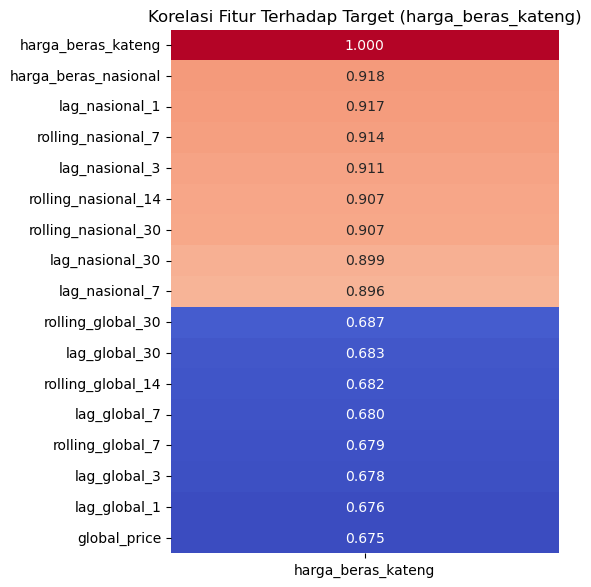


🔥 Korelasi terhadap harga_beras_kateng:
harga_beras_kateng      1.000000
harga_beras_nasional    0.918486
lag_nasional_1          0.916947
rolling_nasional_7      0.914319
lag_nasional_3          0.910606
rolling_nasional_14     0.907367
rolling_nasional_30     0.907316
lag_nasional_30         0.898688
lag_nasional_7          0.895555
rolling_global_30       0.686582
lag_global_30           0.682753
rolling_global_14       0.682320
lag_global_7            0.680120
rolling_global_7        0.679381
lag_global_3            0.678063
lag_global_1            0.675999
global_price            0.675014
Name: harga_beras_kateng, dtype: float64


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load feature dataset
df_fe = pd.read_csv("CleanedDataset/Dataset_With_Features.csv")

# 2. Ambil hanya kolom numerik
numerics = df_fe.select_dtypes(include=['float64', 'int64'])

# 3. Hitung korelasi terhadap target
target_corr = numerics.corr()['harga_beras_kateng'].sort_values(ascending=False)

print("\n🔥 Korelasi terhadap harga_beras_kateng:")
print(target_corr)

# 4. Visualisasikan sebagai heatmap 1 kolom
plt.figure(figsize=(5, len(target_corr) * 0.4))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".3f", cbar=False)
plt.title("Korelasi Fitur Terhadap Target (harga_beras_kateng)")
plt.show()

# 4. Fokus pada korelasi terhadap target saja
target_corr = corr["harga_beras_kateng"].sort_values(ascending=False)
print("\n🔥 Korelasi terhadap harga_beras_kateng:")
print(target_corr)

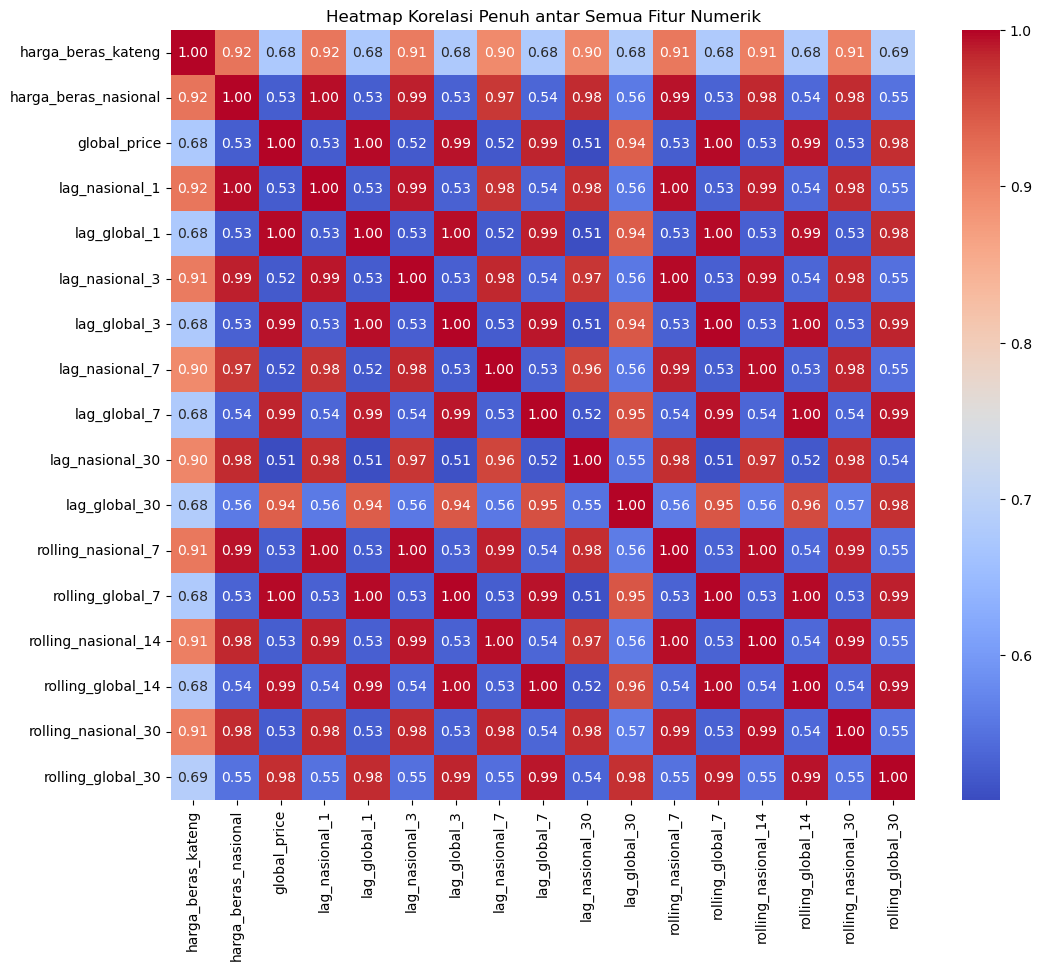

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df_fe = pd.read_csv("CleanedDataset/Dataset_With_Features.csv")

# 2. Ambil hanya kolom numerik
numerics = df_fe.select_dtypes(include=['float64', 'int64'])

# 3. Hitung korelasi antar semua fitur
corr_matrix = numerics.corr()

# 4. Visualisasikan heatmap korelasi penuh
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap Korelasi Penuh antar Semua Fitur Numerik")
plt.show()

In [29]:
import pandas as pd

# 1. Load dataset feature engineering sebelumnya
df = pd.read_csv("CleanedDataset/Dataset_With_Features.csv", parse_dates=["date"])

# 2. Pilih hanya fitur yang kamu tentukan
selected_features = [
    "harga_beras_kateng",  # target
    "date",

    # Nasional Top 5
    "harga_beras_nasional", "lag_nasional_1", "rolling_nasional_7",
    "lag_nasional_3", "rolling_nasional_14",

    # Global Top 5
    "rolling_global_30", "lag_global_30", "rolling_global_14",
    "lag_global_7", "global_price"
]

df_selected = df[selected_features]

# 3. Simpan ke file baru
output_path = "CleanedDataset/Dataset_With_Features2.csv"
df_selected.to_csv(output_path, index=False)

print(f"✅ Dataset berhasil disimpan ke {output_path}")
print(df_selected.head())

✅ Dataset berhasil disimpan ke CleanedDataset/Dataset_With_Features2.csv
   harga_beras_kateng       date  harga_beras_nasional  lag_nasional_1  \
0        13392.857143 2017-02-07               11250.0         11350.0   
1        13400.000000 2017-02-08               11150.0         11250.0   
2        13250.000000 2017-02-09               11225.0         11150.0   
3        13100.000000 2017-02-10               11300.0         11225.0   
4        13200.000000 2017-02-11               11350.0         11300.0   

   rolling_nasional_7  lag_nasional_3  rolling_nasional_14  rolling_global_30  \
0        11264.285714         11275.0         11182.142857         374.666667   
1        11257.142857         11300.0         11191.071429         374.333333   
2        11257.142857         11350.0         11203.571429         374.000000   
3        11264.285714         11250.0         11219.642857         373.666667   
4        11275.000000         11150.0         11237.500000         373.333333

In [31]:
### Data Normalization ###
###--------------------###

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

# 1. Load dataset utama
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# 2. Pisahkan kolom non-numerik dan kolom target
date_col = df["date"]
target_col = df["harga_beras_kateng"]
feature_cols = df.drop(columns=["date", "harga_beras_kateng"])

# 3. Siapkan scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

# 4. Fit dan transform fitur (target dan date tidak dinormalisasi)
features_minmax = scaler_minmax.fit_transform(feature_cols)
features_standard = scaler_standard.fit_transform(feature_cols)

# 5. Buat DataFrame hasil normalisasi
df_minmax = pd.DataFrame(features_minmax, columns=feature_cols.columns)
df_standard = pd.DataFrame(features_standard, columns=feature_cols.columns)

# 6. Gabungkan kembali dengan date dan target asli
df_minmax.insert(0, "date", date_col)
df_minmax.insert(1, "harga_beras_kateng", target_col)

df_standard.insert(0, "date", date_col)
df_standard.insert(1, "harga_beras_kateng", target_col)

# 7. Simpan dataset
df_minmax.to_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", index=False)
df_standard.to_csv("NormalizedDataset/Dataset_Normalized_Standard.csv", index=False)

# 8. Simpan scaler ke file .pkl
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
joblib.dump(scaler_standard, "scaler_standard.pkl")

print("✅ Normalisasi selesai!")
print("✅ Disimpan: Dataset_Normalized_MinMax.csv, Dataset_Normalized_Standard.csv, scaler_minmax.pkl, scaler_standard.pkl")

✅ Normalisasi selesai!
✅ Disimpan: Dataset_Normalized_MinMax.csv, Dataset_Normalized_Standard.csv, scaler_minmax.pkl, scaler_standard.pkl


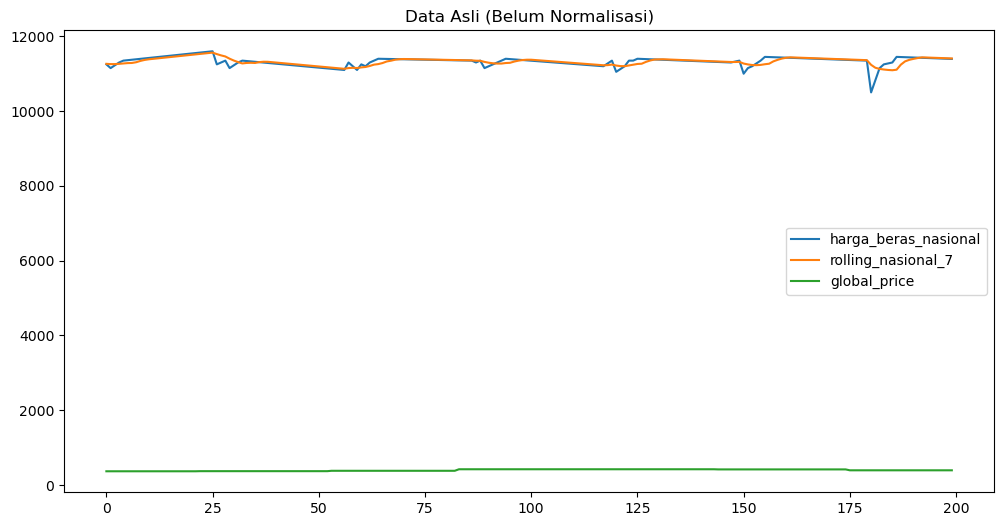

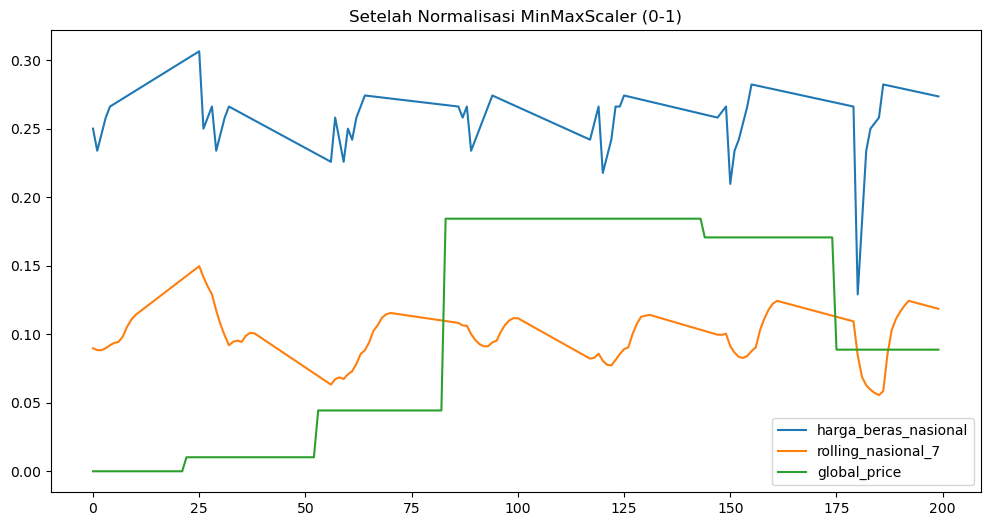

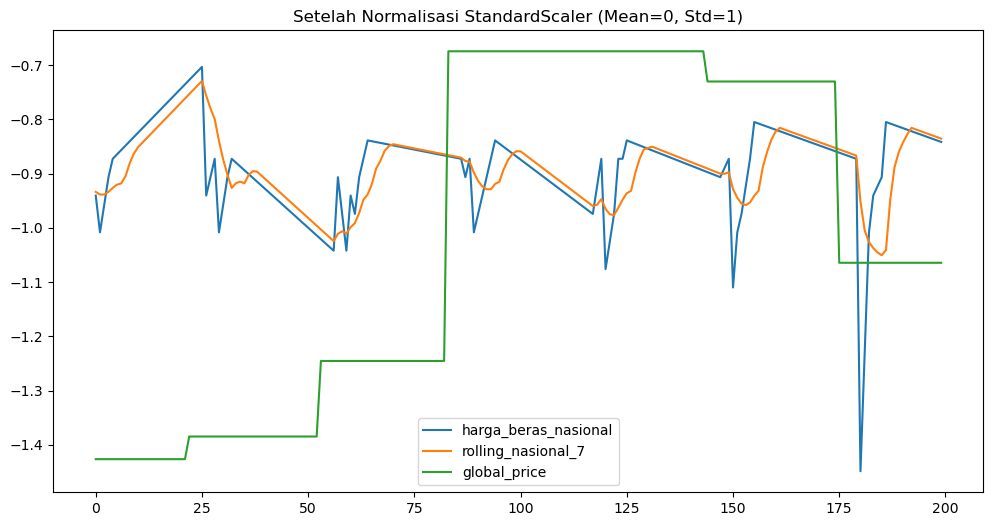

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load semua dataset
df_raw = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv")
df_minmax = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv")
df_standard = pd.read_csv("NormalizedDataset/Dataset_Normalized_Standard.csv")

# 2. Pilih fitur untuk visualisasi (contoh 3 fitur dominan)
features_to_plot = ["harga_beras_nasional", "rolling_nasional_7", "global_price"]

# 3. Plot untuk dataset asli
plt.figure(figsize=(12,6))
for col in features_to_plot:
    plt.plot(df_raw[col].iloc[:200], label=col)  # ambil 200 data pertama agar tidak terlalu rapat
plt.title("Data Asli (Belum Normalisasi)")
plt.legend()
plt.show()

# 4. Plot untuk MinMax Scaler
plt.figure(figsize=(12,6))
for col in features_to_plot:
    plt.plot(df_minmax[col].iloc[:200], label=col)
plt.title("Setelah Normalisasi MinMaxScaler (0-1)")
plt.legend()
plt.show()

# 5. Plot untuk Standard Scaler
plt.figure(figsize=(12,6))
for col in features_to_plot:
    plt.plot(df_standard[col].iloc[:200], label=col)
plt.title("Setelah Normalisasi StandardScaler (Mean=0, Std=1)")
plt.legend()
plt.show()

Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 256438576.0000 - val_loss: 75815104.0000
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2519921.2500 - val_loss: 163049.1875
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 120356.9141 - val_loss: 161802.0156
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 119716.1562 - val_loss: 162657.3906
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 120545.8672 - val_loss: 162214.7500
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119154.6641 - val_loss: 163378.0156
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 117401.9688 - val_loss: 157376.1250
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119501.3203 - val_loss: 159704.7500
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 115312.7500 - val_loss: 159203.8594
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 115095.8750 - val_loss: 162355.1875
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1136

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


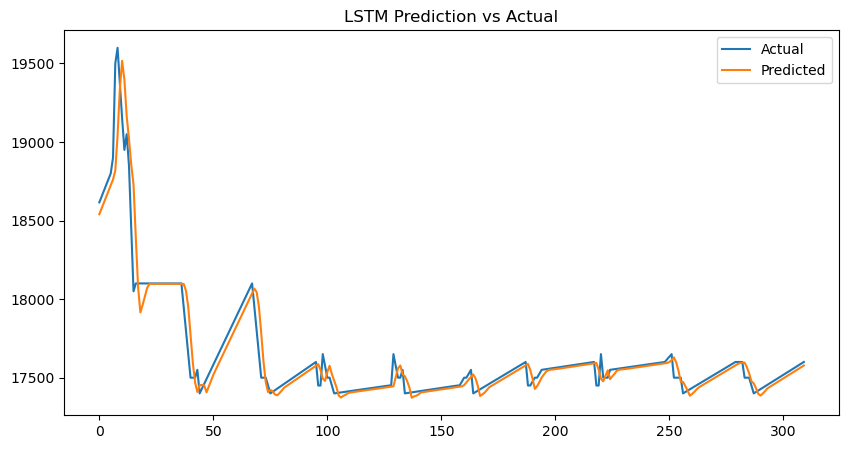

In [82]:
######################################
### LSTM --- Dataset_MinMax_Scaler ###
######################################

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ============================
# 1. Load Data
# ============================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])  # Selain tanggal

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# ============================
# 3. Create Windowing
# ============================
def create_sequences(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps, :])  
        y.append(data[i + timesteps, 0])    # Kolom 0 = target (harga_beras_kateng)
    return np.array(X), np.array(y)

timesteps = 7

X_train, y_train = create_sequences(train_data, timesteps)
X_val, y_val = create_sequences(val_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

# ============================
# 4. Build Model
# ============================
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ============================
# 5. Train Model
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# ============================
# 6. Evaluation on Test Set
# ============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ MAE  : {mae:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("LSTM Prediction vs Actual (MinMax Normalization)")
plt.legend()
plt.show()

Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 18128374.0000 - val_loss: 429203.9375
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 728646.5000 - val_loss: 482429.1562
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 675338.0000 - val_loss: 530825.6250
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 648549.5000 - val_loss: 489076.3125
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 613190.5625 - val_loss: 392082.9688
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 585881.0000 - val_loss: 494779.2812
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 550716.0625 - val_loss: 387289.2188
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 513788.4375 - val_loss: 297353.7500
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 458985.7500 - val_loss: 371874.6875
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 424938.5000 - val_loss: 334603.6562
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 414070.31

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


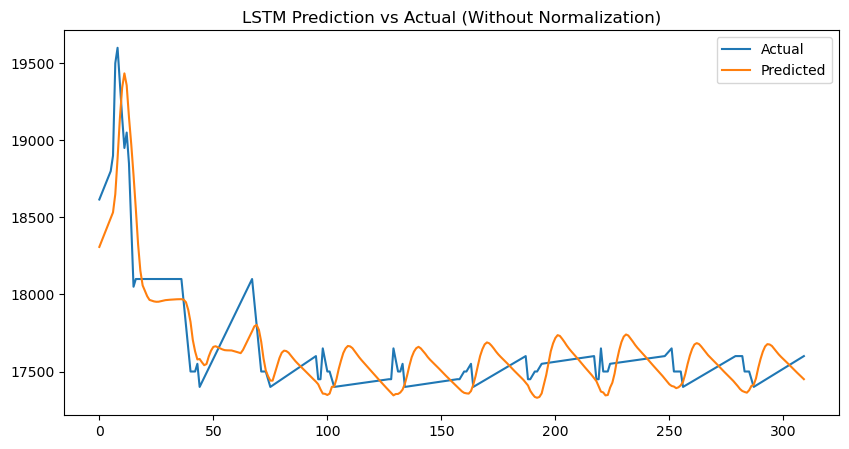

In [61]:
##########################################
### LSTM --- Dataset_Tanpa_Normalisasi ###
##########################################


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ============================
# 1. Load Data
# ============================
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])  # Selain tanggal

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# ============================
# 3. Create Windowing
# ============================
def create_sequences(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps, :])  
        y.append(data[i + timesteps, 0])    # Kolom 0 = target (harga_beras_kateng)
    return np.array(X), np.array(y)

timesteps = 7

X_train, y_train = create_sequences(train_data, timesteps)
X_val, y_val = create_sequences(val_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

# ============================
# 4. Build Model
# ============================
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ============================
# 5. Train Model
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# ============================
# 6. Evaluation on Test Set
# ============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ MAE  : {mae:.4f} Rupiah")
print(f"✅ RMSE : {rmse:.4f} Rupiah")
print(f"✅ MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("LSTM Prediction vs Actual (Without Normalization)")
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 56281732.0000 - val_loss: 312584.1875
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1623083.7500 - val_loss: 446664.3125
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 136328.3906 - val_loss: 143617.4688
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 104796.1016 - val_loss: 142964.9062
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 105135.6641 - val_loss: 142882.8750
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 104791.2734 - val_loss: 142855.8438
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 104924.4922 - val_loss: 143268.7969
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 104852.5234 - val_loss: 143546.7812
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 104801.4766 - val_loss: 142920.1719
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 104685.2734 - val_loss: 142637.5781
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


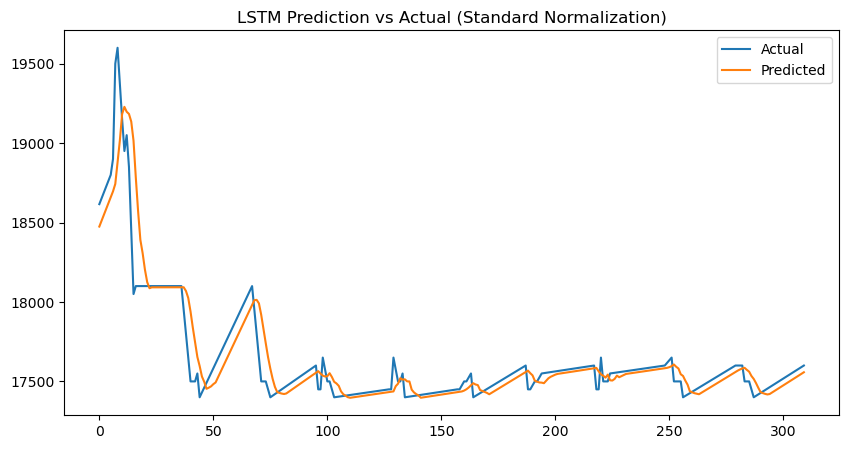

In [51]:
########################################
### LSTM --- Dataset_Standard_Scaler ###
########################################


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ============================
# 1. Load Data
# ============================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Standard.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])  # Selain tanggal

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# ============================
# 3. Create Windowing
# ============================
def create_sequences(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps, :])  
        y.append(data[i + timesteps, 0])    # Kolom 0 = target (harga_beras_kateng)
    return np.array(X), np.array(y)

timesteps = 7

X_train, y_train = create_sequences(train_data, timesteps)
X_val, y_val = create_sequences(val_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

# ============================
# 4. Build Model
# ============================
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ============================
# 5. Train Model
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# ============================
# 6. Evaluation on Test Set
# ============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ MAE  : {mae:.4f} Rupiah")
print(f"✅ RMSE : {rmse:.4f} Rupiah")
print(f"✅ MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("LSTM Prediction vs Actual (Standard Normalization)")
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ KNN MinMax → MAE  : 875.6894 Rupiah
✅ KNN MinMax → RMSE : 913.1047 Rupiah
✅ KNN MinMax → MAPE : 4.98%


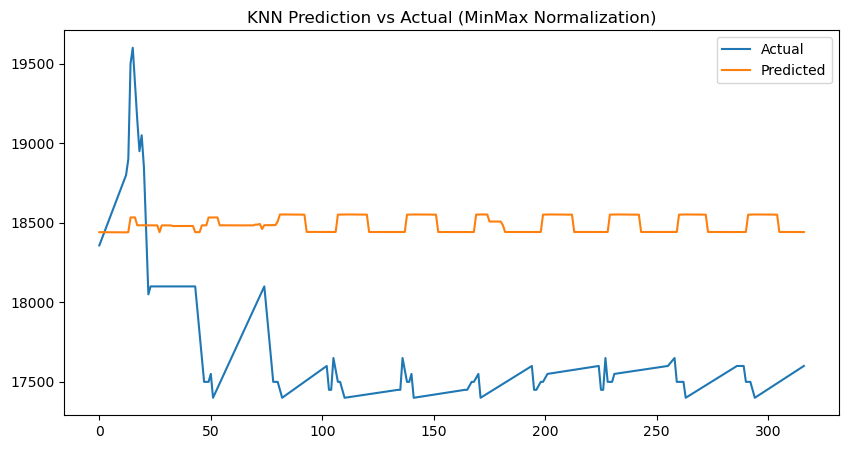

In [53]:
#####################################
### KNN --- Dataset_MinMax_Scaler ###
#####################################

import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ============================
# 1. Load data
# ============================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test (80/10/10)
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# ============================
# 3. Train KNN
# ============================
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# ============================
# 4. Evaluate
# ============================
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ KNN MinMax → MAE  : {mae:.4f} Rupiah")
print(f"✅ KNN MinMax → RMSE : {rmse:.4f} Rupiah")
print(f"✅ KNN MinMax → MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("KNN Prediction vs Actual (MinMax Normalization)")
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ KNN MinMax → MAE  : 931.1785 Rupiah
✅ KNN MinMax → RMSE : 967.7143 Rupiah
✅ KNN MinMax → MAPE : 5.30%


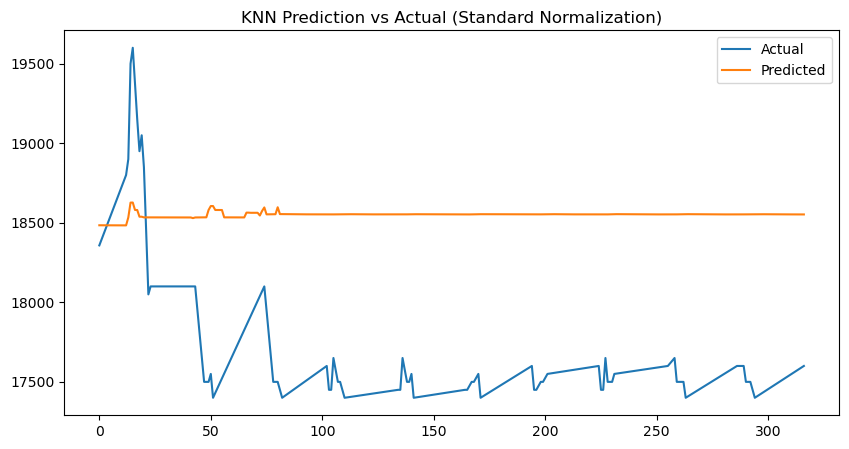

In [59]:
#######################################
### KNN --- Dataset_Standard_Scaler ###
#######################################

import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ============================
# 1. Load data
# ============================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Standard.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test (80/10/10)
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# ============================
# 3. Train KNN
# ============================
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# ============================
# 4. Evaluate
# ============================
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ KNN MinMax → MAE  : {mae:.4f} Rupiah")
print(f"✅ KNN MinMax → RMSE : {rmse:.4f} Rupiah")
print(f"✅ KNN MinMax → MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("KNN Prediction vs Actual (Standard Normalization)")
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ KNN MinMax → MAE  : 1393.5489 Rupiah
✅ KNN MinMax → RMSE : 1442.6555 Rupiah
✅ KNN MinMax → MAPE : 7.94%


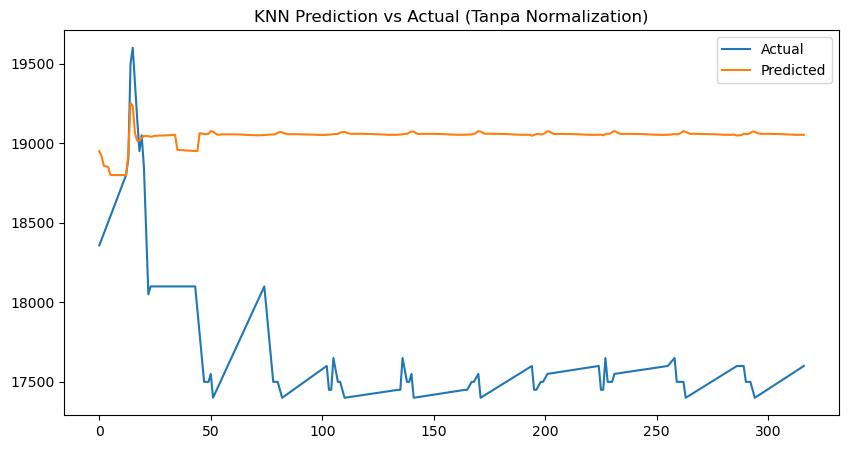

In [61]:
#########################################
### KNN --- Dataset_Tanpa_Normalisasi ###
#########################################

import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ============================
# 1. Load data
# ============================
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# Target dan fitur
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test (80/10/10)
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# ============================
# 3. Train KNN
# ============================
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# ============================
# 4. Evaluate
# ============================
y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ KNN MinMax → MAE  : {mae:.4f} Rupiah")
print(f"✅ KNN MinMax → RMSE : {rmse:.4f} Rupiah")
print(f"✅ KNN MinMax → MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("KNN Prediction vs Actual (Tanpa Normalization)")
plt.legend()
plt.show()

✅ Linear Regression StdScaler → MAE  : 3378.4870 Rupiah
✅ Linear Regression StdScaler → RMSE : 3449.0908 Rupiah
✅ Linear Regression StdScaler → MAPE : 19.21%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


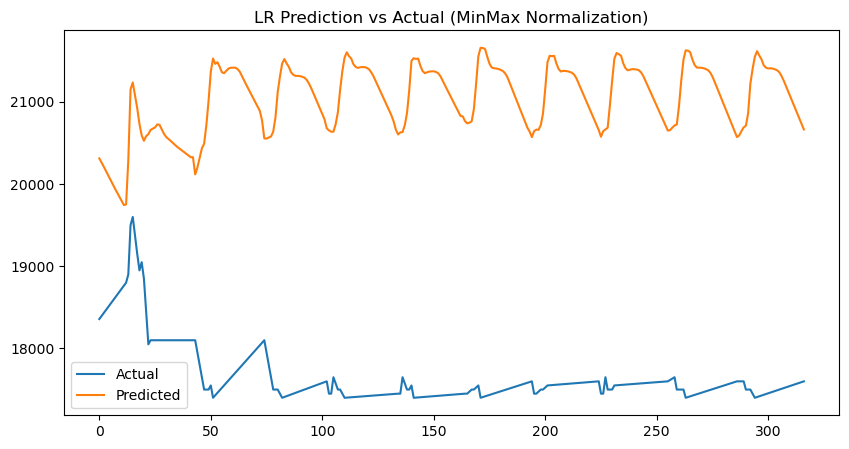

In [37]:
##################################################
### LinearRegression --- Dataset_MinMax_Scaler ###
##################################################

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ============================
# 1. Load data
# ============================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", parse_dates=["date"])

# Drop kolom date dan splis X-y
target_col = "harga_beras_kateng"
feature_cols = df.columns.drop(["date"])

data = df[feature_cols].values

# ============================
# 2. Split Train / Val / Test (80/10/10)
# ============================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# ============================
# 3. Train Linear Regression
# ============================
model = LinearRegression()
model.fit(X_train, y_train)

# ============================
# 4. Evaluate
# ============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"✅ Linear Regression StdScaler → MAE  : {mae:.4f} Rupiah")
print(f"✅ Linear Regression StdScaler → RMSE : {rmse:.4f} Rupiah")
print(f"✅ Linear Regression StdScaler → MAPE : {mape:.2f}%")

# ============================
# 7. Plot Real vs Predicted
# ============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("LR Prediction vs Actual (MinMax Normalization)")
plt.legend()
plt.show()

In [1]:
##################################################
### RandomForest --- Dataset_Tidak_Normalisasi ###
##################################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load Raw Dataset
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# 2. Pisahkan fitur dan target
X = df.drop(columns=["date", "harga_beras_kateng"])  # fitur
y = df["harga_beras_kateng"]  # target

# 3. Train-test split (80/10/10)
train_size = 0.8
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 4. Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,       # jumlah pohon
    max_depth=None,         # biarkan pohon tumbuh maksimal
    random_state=42
)
rf.fit(X_train, y_train)

# 5. Prediksi
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

# 6. Evaluasi
def evaluate(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"📌 {label} Evaluation:")
    print(f"✅ MAE  : {mae:.4f} Rupiah")
    print(f"✅ RMSE : {rmse:.4f} Rupiah")
    print(f"✅ MAPE : {mape:.2f}%\n")

evaluate(y_val, y_pred_val, "Validation")
evaluate(y_test, y_pred_test, "Testing")

Train: 2527, Val: 316, Test: 316
📌 Validation Evaluation:
✅ MAE  : 382.4391 Rupiah
✅ RMSE : 452.5861 Rupiah
✅ MAPE : 2.07%

📌 Testing Evaluation:
✅ MAE  : 1449.0005 Rupiah
✅ RMSE : 1527.0147 Rupiah
✅ MAPE : 8.26%



In [73]:
!pip install optuna

[I 2025-10-04 18:14:36,914] A new study created in memory with name: no-name-39812dd4-c915-40d5-8cd7-7cc5ca92942d
[I 2025-10-04 18:14:40,763] Trial 0 finished with value: 430.53562044063005 and parameters: {'n_estimators': 401, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 0 with value: 430.53562044063005.
[I 2025-10-04 18:14:42,694] Trial 1 finished with value: 408.26245590372827 and parameters: {'n_estimators': 194, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 408.26245590372827.
[I 2025-10-04 18:14:46,690] Trial 2 finished with value: 437.6894857614767 and parameters: {'n_estimators': 368, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 408.26245590372827.
[I 2025-10-04 18:14:49,473] Trial 3 finished with value: 384.41046914908253 and parameters: {'n_estimators': 217, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with valu

🎯 Best Params: {'n_estimators': 107, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}
📌 Validation Evaluation:
✅ MAE  : 348.0022 Rupiah
✅ RMSE : 406.5476 Rupiah
✅ MAPE : 1.88%

📌 Testing Evaluation:
✅ MAE  : 1411.0428 Rupiah
✅ RMSE : 1494.4649 Rupiah
✅ MAPE : 8.04%



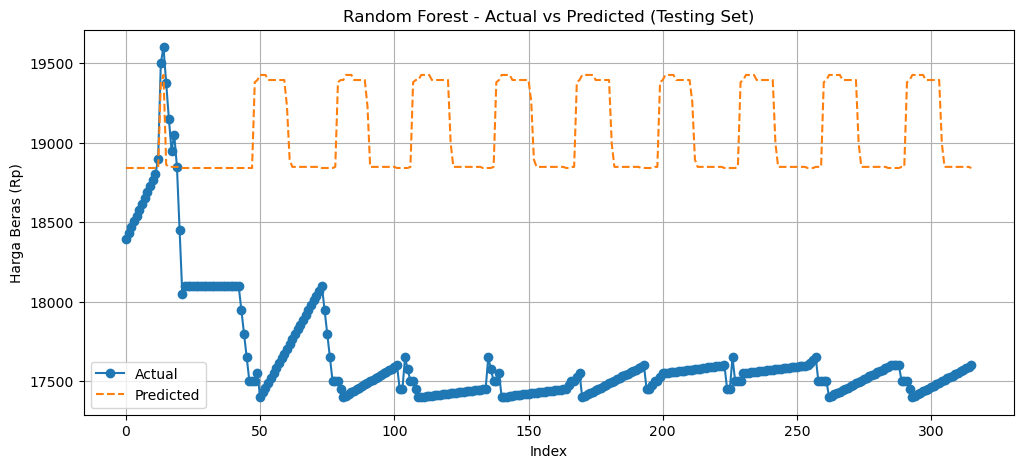

In [21]:
###############################################################
### RandomForest + Tuning Optuna --- Data_Tanpa_Normalisasi ###
###############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Load Dataset Raw ---
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])
X = df.drop(columns=["date", "harga_beras_kateng"])
y = df["harga_beras_kateng"]

# --- Train / Val / Test Split ---
train_size, val_size = 0.8, 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# --- Fungsi Evaluasi ---
def evaluate(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"📌 {label} Evaluation:")
    print(f"✅ MAE  : {mae:.4f} Rupiah")
    print(f"✅ RMSE : {rmse:.4f} Rupiah")
    print(f"✅ MAPE : {mape:.2f}%\n")
    return mae

# --- Fungsi Objective untuk Optuna ---
def objective(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    return mean_absolute_error(y_val, y_pred)

# --- Jalankan Optuna ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("🎯 Best Params:", study.best_params)

# --- Train Model Terbaik ---
best_rf = RandomForestRegressor(**study.best_params, random_state=42)
best_rf.fit(X_train, y_train)

# --- Prediksi ---
y_pred_val = best_rf.predict(X_val)
y_pred_test = best_rf.predict(X_test)

evaluate(y_val, y_pred_val, "Validation")
evaluate(y_test, y_pred_test, "Testing")

# --- Plot Comparison ---
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="Predicted", linestyle='dashed')
plt.title("Random Forest - Actual vs Predicted (Testing Set)")
plt.xlabel("Index")
plt.ylabel("Harga Beras (Rp)")
plt.legend()
plt.grid()
plt.show()

In [7]:
##############################################
### RandomForest --- Dataset_MinMax_Scaler ###
##############################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load Raw Dataset
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Minmax.csv", parse_dates=["date"])

# 2. Pisahkan fitur dan target
X = df.drop(columns=["date", "harga_beras_kateng"])  # fitur
y = df["harga_beras_kateng"]  # target

# 3. Train-test split (80/10/10)
train_size = 0.8
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 4. Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,       # jumlah pohon
    max_depth=None,         # biarkan pohon tumbuh maksimal
    random_state=42
)
rf.fit(X_train, y_train)

# 5. Prediksi
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

# 6. Evaluasi
def evaluate(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"📌 {label} Evaluation:")
    print(f"✅ MAE  : {mae:.4f} Rupiah")
    print(f"✅ RMSE : {rmse:.4f} Rupiah")
    print(f"✅ MAPE : {mape:.2f}%\n")

evaluate(y_val, y_pred_val, "Validation")
evaluate(y_test, y_pred_test, "Testing")

Train: 2527, Val: 316, Test: 316
📌 Validation Evaluation:
✅ MAE  : 382.5086 Rupiah
✅ RMSE : 452.6424 Rupiah
✅ MAPE : 2.07%

📌 Testing Evaluation:
✅ MAE  : 1449.0397 Rupiah
✅ RMSE : 1527.0398 Rupiah
✅ MAPE : 8.26%



In [5]:
################################################
### RandomForest --- Dataset_Standard_Scaler ###
################################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load Raw Dataset
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Minmax.csv", parse_dates=["date"])

# 2. Pisahkan fitur dan target
X = df.drop(columns=["date", "harga_beras_kateng"])  # fitur
y = df["harga_beras_kateng"]  # target

# 3. Train-test split (80/10/10)
train_size = 0.8
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 4. Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,       # jumlah pohon
    max_depth=None,         # biarkan pohon tumbuh maksimal
    random_state=42
)
rf.fit(X_train, y_train)

# 5. Prediksi
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

# 6. Evaluasi
def evaluate(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"📌 {label} Evaluation:")
    print(f"✅ MAE  : {mae:.4f} Rupiah")
    print(f"✅ RMSE : {rmse:.4f} Rupiah")
    print(f"✅ MAPE : {mape:.2f}%\n")

evaluate(y_val, y_pred_val, "Validation")
evaluate(y_test, y_pred_test, "Testing")

Train: 2527, Val: 316, Test: 316
📌 Validation Evaluation:
✅ MAE  : 382.5086 Rupiah
✅ RMSE : 452.6424 Rupiah
✅ MAPE : 2.07%

📌 Testing Evaluation:
✅ MAE  : 1449.0397 Rupiah
✅ RMSE : 1527.0398 Rupiah
✅ MAPE : 8.26%



✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):
MAE  : 1497.1567
RMSE : 1583.9763
MAPE : 8.53%


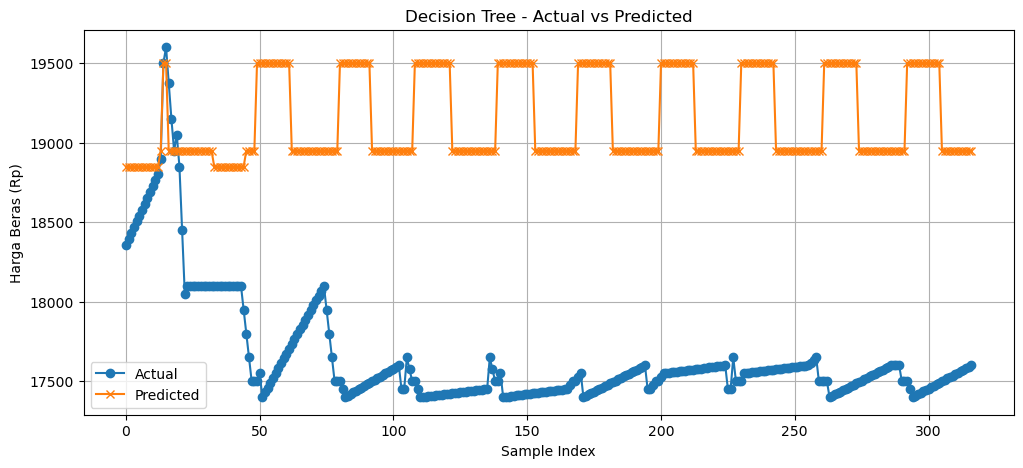

In [13]:
##################################################
### DecisionTree --- Dataset_Tidak_Normalisasi ###
##################################################

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load dataset (RAW / TANPA NORMALISASI)
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# 2. Split Train (80%) - Val (10%) - Test (10%)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

df_train = df[:train_size]
df_val = df[train_size:train_size + val_size]
df_test = df[train_size + val_size:]

# 3. Pisahkan fitur dan target
X_train, y_train = df_train.drop(columns=["date", "harga_beras_kateng"]), df_train["harga_beras_kateng"]
X_val, y_val = df_val.drop(columns=["date", "harga_beras_kateng"]), df_val["harga_beras_kateng"]
X_test, y_test = df_test.drop(columns=["date", "harga_beras_kateng"]), df_test["harga_beras_kateng"]

# 4. Train Decision Tree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Prediksi
y_pred_test = model.predict(X_test)

# 6. Evaluasi
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# 7. Plot Prediksi vs Aktual
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="Predicted", marker='x')
plt.title("Decision Tree - Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Harga Beras (Rp)")
plt.legend()
plt.grid(True)
plt.show()

✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):
MAE  : 1497.4722
RMSE : 1584.1356
MAPE : 8.53%


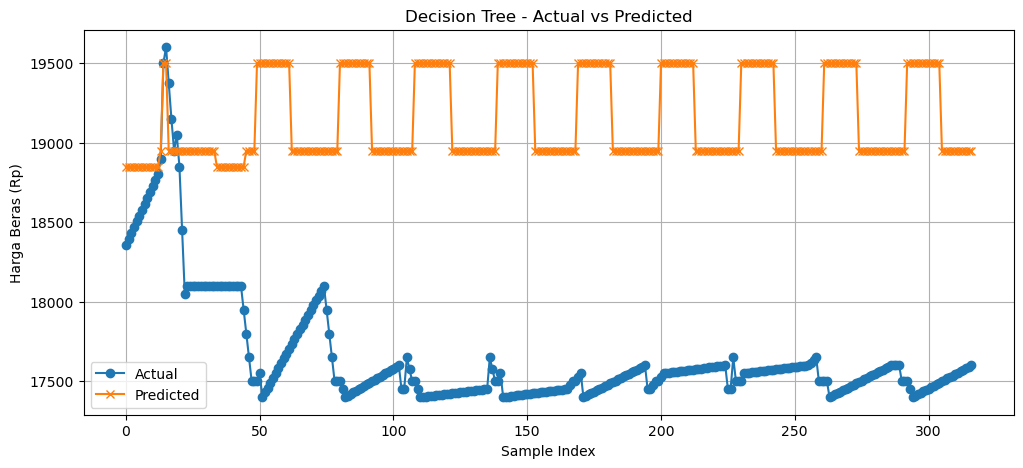

In [15]:
##############################################
### DecisionTree --- Dataset_Minmax_Scaler ###
##############################################

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load dataset (RAW / TANPA NORMALISASI)
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Minmax.csv", parse_dates=["date"])

# 2. Split Train (80%) - Val (10%) - Test (10%)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

df_train = df[:train_size]
df_val = df[train_size:train_size + val_size]
df_test = df[train_size + val_size:]

# 3. Pisahkan fitur dan target
X_train, y_train = df_train.drop(columns=["date", "harga_beras_kateng"]), df_train["harga_beras_kateng"]
X_val, y_val = df_val.drop(columns=["date", "harga_beras_kateng"]), df_val["harga_beras_kateng"]
X_test, y_test = df_test.drop(columns=["date", "harga_beras_kateng"]), df_test["harga_beras_kateng"]

# 4. Train Decision Tree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Prediksi
y_pred_test = model.predict(X_test)

# 6. Evaluasi
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# 7. Plot Prediksi vs Aktual
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="Predicted", marker='x')
plt.title("Decision Tree - Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Harga Beras (Rp)")
plt.legend()
plt.grid(True)
plt.show()

✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):
MAE  : 1502.3618
RMSE : 1589.6346
MAPE : 8.56%


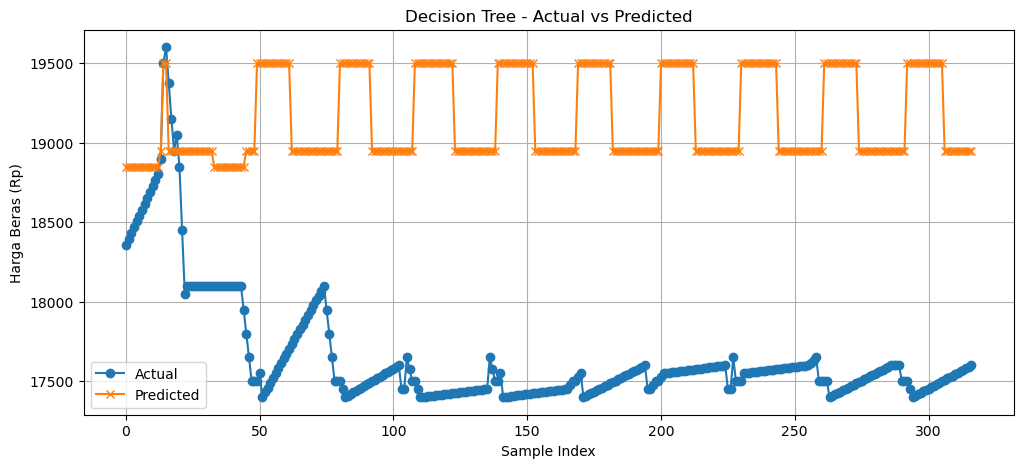

In [19]:
################################################
### DecisionTree --- Dataset_Standard_Scaler ###
################################################

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load dataset (RAW / TANPA NORMALISASI)
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_Standard.csv", parse_dates=["date"])

# 2. Split Train (80%) - Val (10%) - Test (10%)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

df_train = df[:train_size]
df_val = df[train_size:train_size + val_size]
df_test = df[train_size + val_size:]

# 3. Pisahkan fitur dan target
X_train, y_train = df_train.drop(columns=["date", "harga_beras_kateng"]), df_train["harga_beras_kateng"]
X_val, y_val = df_val.drop(columns=["date", "harga_beras_kateng"]), df_val["harga_beras_kateng"]
X_test, y_test = df_test.drop(columns=["date", "harga_beras_kateng"]), df_test["harga_beras_kateng"]

# 4. Train Decision Tree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Prediksi
y_pred_test = model.predict(X_test)

# 6. Evaluasi
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"✅ Hasil Model Decision Tree (RAW / Tanpa Normalisasi):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# 7. Plot Prediksi vs Aktual
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="Predicted", marker='x')
plt.title("Decision Tree - Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Harga Beras (Rp)")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


✅ Hasil Model XGBoost (RAW / Tanpa Normalisasi):
MAE  : 1193.2645
RMSE : 1233.6908
MAPE : 6.79%


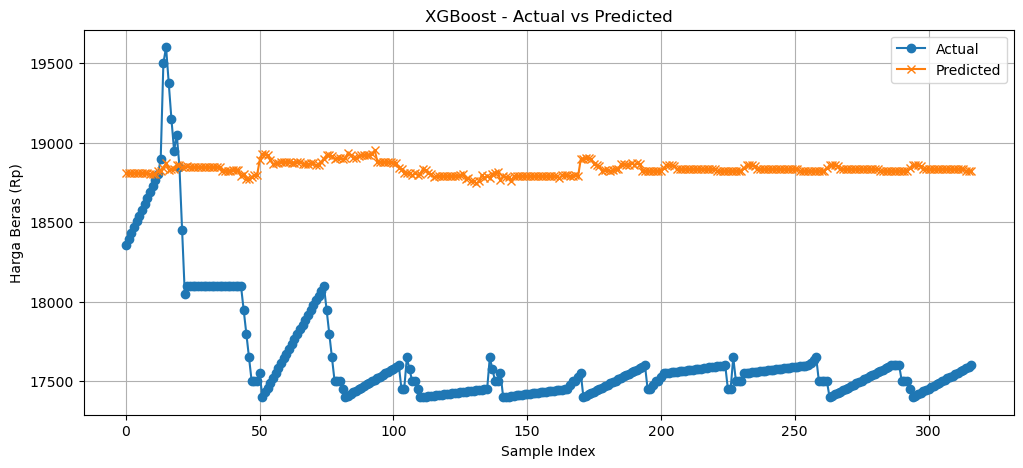

In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load dataset (RAW / TANPA NORMALISASI)
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# 2. Split Train (80%) - Val (10%) - Test (10%)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

df_train = df[:train_size]
df_val = df[train_size:train_size + val_size]
df_test = df[train_size + val_size:]

# 3. Pisahkan fitur & target
X_train, y_train = df_train.drop(columns=["date", "harga_beras_kateng"]), df_train["harga_beras_kateng"]
X_val, y_val     = df_val.drop(columns=["date", "harga_beras_kateng"]), df_val["harga_beras_kateng"]
X_test, y_test   = df_test.drop(columns=["date", "harga_beras_kateng"]), df_test["harga_beras_kateng"]

# 4. Train XGBoost
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

# 5. Prediksi
y_pred_test = model.predict(X_test)

# 6. Evaluasi
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"✅ Hasil Model XGBoost (RAW / Tanpa Normalisasi):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# 7. Plot Prediksi vs Aktual
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="Predicted", marker='x')
plt.title("XGBoost - Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Harga Beras (Rp)")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
####################################################################################
### Stacked LSTM + Tuning Optuna + Timestep 7 ######################################
####################################################################################

import optuna
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ======================================
# Load Dataset
# ======================================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", parse_dates=["date"])
feature_cols = df.columns.drop(["date"])
data = df[feature_cols].values

# ======================================
# Train / Val / Test Split (80/10/10)
# ======================================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# ======================================
# Create Sequences (Timesteps = 7)
# ======================================
def create_sequences(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps, :])
        y.append(data[i + timesteps, 0])
    return np.array(X), np.array(y)

timesteps = 7
X_train, y_train = create_sequences(train_data, timesteps)
X_val, y_val = create_sequences(val_data, timesteps)

# ======================================
# Objective Function Optuna
# ======================================
def objective(trial):
    units = trial.suggest_int("units", 16, 128, step=16)
    learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    model = Sequential([
        LSTM(units, activation='relu', input_shape=(timesteps, X_train.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# ======================================
# Run Optuna (20 Trials)
# ======================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("✅ Best Parameters:", study.best_params)
print("🎯 Best MAE:", study.best_value)


[I 2025-10-04 18:59:37,831] A new study created in memory with name: no-name-2e41a9ab-b753-4f95-84c0-134b2fd6fca4
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 18:59:52,312] Trial 0 finished with value: 9590.712672795271 and parameters: {'units': 16, 'lr': 5.4743284495647046e-05}. Best is trial 0 with value: 9590.712672795271.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-10-04 19:00:08,156] Trial 1 finished with value: 305.7887085412563 and parameters: {'units': 32, 'lr': 0.001124161757637435}. Best is trial 1 with value: 305.7887085412563.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:00:24,274] Trial 2 finished with value: 294.85900835862645 and parameters: {'units': 64, 'lr': 0.0033293225833102686}. Best is trial 2 with value: 294.85900835862645.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:00:36,109] Trial 3 finished with value: 279.9333829714725 and parameters: {'units': 64, 'lr': 0.0008630403592984019}. Best is trial 3 with value: 279.9333829714725.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:00:43,230] Trial 4 finished with value: 165.9049432812026 and parameters: {'units': 112, 'lr': 0.000159303019440362}. Best is trial 4 with value: 165.9049432812026.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:00:57,404] Trial 5 finished with value: 301.38015664393487 and parameters: {'units': 16, 'lr': 0.002847861308816332}. Best is trial 4 with value: 165.9049432812026.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:01:08,124] Trial 6 finished with value: 185.0684243933443 and parameters: {'units': 48, 'lr': 0.003555940154259931}. Best is trial 4 with value: 165.9049432812026.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:01:20,064] Trial 7 finished with value: 247.7790228740394 and parameters: {'units': 80, 'lr': 0.005005486946095067}. Best is trial 4 with value: 165.9049432812026.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:01:36,956] Trial 8 finished with value: 13355.608285239465 and parameters: {'units': 80, 'lr': 1.2740211704368622e-05}. Best is trial 4 with value: 165.9049432812026.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:01:50,432] Trial 9 finished with value: 152.6943223807541 and parameters: {'units': 48, 'lr': 4.9142402734140705e-05}. Best is trial 9 with value: 152.6943223807541.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:02:09,980] Trial 10 finished with value: 9468.48330743407 and parameters: {'units': 128, 'lr': 1.062915412409391e-05}. Best is trial 9 with value: 152.6943223807541.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:02:20,226] Trial 11 finished with value: 276.69160398565566 and parameters: {'units': 112, 'lr': 0.000124099089191975}. Best is trial 9 with value: 152.6943223807541.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-10-04 19:02:31,116] Trial 12 finished with value: 122.60150876569983 and parameters: {'units': 96, 'lr': 7.222641138859316e-05}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-10-04 19:02:48,574] Trial 13 finished with value: 733.9784563281427 and parameters: {'units': 96, 'lr': 3.964956245377605e-05}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:03:05,536] Trial 14 finished with value: 180.98462018691546 and parameters: {'units': 48, 'lr': 3.845561860148025e-05}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:03:16,225] Trial 15 finished with value: 221.14064489806103 and parameters: {'units': 96, 'lr': 0.0002635439941992852}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:03:31,699] Trial 16 finished with value: 256.2415418407693 and parameters: {'units': 48, 'lr': 7.492127700362095e-05}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-10-04 19:03:50,331] Trial 17 finished with value: 661.0144707694307 and parameters: {'units': 96, 'lr': 2.1948276506163615e-05}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:03:57,354] Trial 18 finished with value: 315.76716075310696 and parameters: {'units': 32, 'lr': 0.0005113862013331292}. Best is trial 12 with value: 122.60150876569983.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\297926528.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[I 2025-10-04 19:04:07,524] Trial 19 finished with value: 117.94891340800417 and parameters: {'units': 128, 'lr': 0.00012598029216777994}. Best is trial 19 with value: 117.94891340800417.


✅ Best Parameters: {'units': 128, 'lr': 0.00012598029216777994}
🎯 Best MAE: 117.94891340800417


In [47]:
####################################################################################
### Stacked LSTM + Tuning Optuna + Timestep 14 #####################################
####################################################################################

import optuna
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ======================================
# Load Dataset
# ======================================
df = pd.read_csv("NormalizedDataset/Dataset_Normalized_MinMax.csv", parse_dates=["date"])
feature_cols = df.columns.drop(["date"])
data = df[feature_cols].values

# ======================================
# Train / Val / Test Split (80/10/10)
# ======================================
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# ======================================
# Create Sequences (Timesteps = 14)
# ======================================
def create_sequences(data, timesteps=14):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps, :])
        y.append(data[i + timesteps, 0])
    return np.array(X), np.array(y)

timesteps = 14
X_train, y_train = create_sequences(train_data, timesteps)
X_val, y_val = create_sequences(val_data, timesteps)

# ======================================
# Objective Function Optuna
# ======================================
def objective(trial):
    units = trial.suggest_int("units", 16, 128, step=16)
    learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    model = Sequential([
        LSTM(units, activation='relu', input_shape=(timesteps, X_train.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# ======================================
# Run Optuna (20 Trials)
# ======================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("✅ Best Parameters:", study.best_params)
print("🎯 Best MAE:", study.best_value)

[I 2025-10-04 19:16:57,922] A new study created in memory with name: no-name-e1dfb67e-9f2c-46ae-905d-159133e4c866
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-10-04 19:17:15,140] Trial 0 finished with value: 463.5405396775958 and parameters: {'units': 16, 'lr': 0.00044557464446207926}. Best is trial 0 with value: 463.5405396775958.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:17:21,829] Trial 1 finished with value: 430.86396924035057 and parameters: {'units': 80, 'lr': 0.0014200928520871833}. Best is trial 1 with value: 430.86396924035057.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:17:27,975] Trial 2 finished with value: 297.94055369814697 and parameters: {'units': 80, 'lr': 0.004496006603706339}. Best is trial 2 with value: 297.94055369814697.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:17:39,340] Trial 3 finished with value: 258.0513751339606 and parameters: {'units': 80, 'lr': 0.0002549381544426353}. Best is trial 3 with value: 258.0513751339606.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:17:47,693] Trial 4 finished with value: 406.7070353156562 and parameters: {'units': 80, 'lr': 0.0011719443592479134}. Best is trial 3 with value: 258.0513751339606.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:18:05,153] Trial 5 finished with value: 499.0745339196724 and parameters: {'units': 16, 'lr': 0.0006370933078796652}. Best is trial 3 with value: 258.0513751339606.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:18:15,858] Trial 6 finished with value: 17296.5060609543 and parameters: {'units': 128, 'lr': 1.2767763359427717e-05}. Best is trial 3 with value: 258.0513751339606.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-10-04 19:18:31,324] Trial 7 finished with value: 225.98859510239987 and parameters: {'units': 32, 'lr': 0.007714894113761674}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-10-04 19:18:39,538] Trial 8 finished with value: 464.48960918548613 and parameters: {'units': 32, 'lr': 0.0009152187850836521}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:18:48,620] Trial 9 finished with value: 393.967774632803 and parameters: {'units': 112, 'lr': 0.00010988583937834276}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:19:08,802] Trial 10 finished with value: 350.6589081368981 and parameters: {'units': 48, 'lr': 0.00903617643379858}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-10-04 19:19:28,255] Trial 11 finished with value: 228.7541211280641 and parameters: {'units': 48, 'lr': 9.992274860499377e-05}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:19:44,898] Trial 12 finished with value: 404.2053886056156 and parameters: {'units': 48, 'lr': 3.8031320263756625e-05}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:20:04,755] Trial 13 finished with value: 1739.899464777496 and parameters: {'units': 48, 'lr': 8.953861142342014e-05}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:20:24,302] Trial 14 finished with value: 310.2243214452243 and parameters: {'units': 48, 'lr': 0.003563754408490573}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:20:43,367] Trial 15 finished with value: 4824.521194428658 and parameters: {'units': 32, 'lr': 0.00016544573347988716}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:20:54,215] Trial 16 finished with value: 15850.330596742397 and parameters: {'units': 64, 'lr': 2.4361236650241174e-05}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-10-04 19:21:07,376] Trial 17 finished with value: 6143.149039761923 and parameters: {'units': 32, 'lr': 6.358470423730601e-05}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:21:27,932] Trial 18 finished with value: 12920.480360489704 and parameters: {'units': 64, 'lr': 0.0002882396044849399}. Best is trial 7 with value: 225.98859510239987.
C:\Users\rayva\AppData\Local\Temp\ipykernel_3708\1021208541.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-2)
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-10-04 19:21:36,525] Trial 19 finished with value: 404.1416645232526 and parameters: {'units': 96, 'lr': 0.0022743152939574724}. Best is trial 7 with value: 225.98859510239987.


✅ Best Parameters: {'units': 32, 'lr': 0.007714894113761674}
🎯 Best MAE: 225.98859510239987


In [51]:
################
### Evaluasi ###
################

import pandas as pd

# ==============================
# 1. Masukkan hasil evaluasi secara manual
# ==============================

results = [
    # Format: ("Model", "Dataset", "Description", MAE, RMSE, MAPE)
    ("LSTM", "MinMax", "Best (Baseline)", 50.1038, 99.0121, 1.63),
    ("LSTM", "MinMax", "Tuning Optuna Timestep 7", 117.9489, None, None),
    ("LSTM", "MinMax", "Tuning Optuna Timestep 14", 225.9885, None, None),

    ("KNN", "MinMax", "-", 875.6894, 913.1047, 4.98),
    ("Linear Regression", "StandardScaler", "-", 3378.4870, 3449.0908, 19.21),

    ("RandomForest", "Raw", "Before Tuning (Val)", 382.4391, 452.5861, 2.07),
    ("RandomForest", "Raw", "Before Tuning (Test)", 1449.0005, 1527.0147, 8.26),
    ("RandomForest", "Raw", "After Tuning (Val)", 348.0022, 406.5476, 1.88),
    ("RandomForest", "Raw", "After Tuning (Test)", 1411.0428, 1494.4649, 8.04),

    ("DecisionTree", "Raw", "-", 1497.1567, 1583.9763, 8.53),

    # Tambahkan XGBoost jika sudah ada angkanya
    # ("XGBoost", "Raw", "-", MAE, RMSE, MAPE),
]

# ==============================
# 2. Buat DataFrame ringkasan
# ==============================

df_results = pd.DataFrame(results, columns=["Model", "Dataset", "Description", "MAE", "RMSE", "MAPE"])

# ==============================
# 3. Urutkan dari MAE terbaik
# ==============================

df_results_sorted = df_results.sort_values(by="MAE")

print("\n=== 📊 Ringkasan Evaluasi Semua Model ===")
print(df_results_sorted)

# ==============================
# 4. Simpan ke CSV (optional)
# ==============================

df_results_sorted.to_csv("Model_Performance_Comparison.csv", index=False)
print("\n✅ Disimpan sebagai Model_Performance_Comparison.csv")



=== 📊 Ringkasan Evaluasi Semua Model ===
               Model         Dataset                Description        MAE  \
0               LSTM          MinMax            Best (Baseline)    50.1038   
1               LSTM          MinMax   Tuning Optuna Timestep 7   117.9489   
2               LSTM          MinMax  Tuning Optuna Timestep 14   225.9885   
7       RandomForest             Raw         After Tuning (Val)   348.0022   
5       RandomForest             Raw        Before Tuning (Val)   382.4391   
3                KNN          MinMax                          -   875.6894   
8       RandomForest             Raw        After Tuning (Test)  1411.0428   
6       RandomForest             Raw       Before Tuning (Test)  1449.0005   
9       DecisionTree             Raw                          -  1497.1567   
4  Linear Regression  StandardScaler                          -  3378.4870   

        RMSE   MAPE  
0    99.0121   1.63  
1        NaN    NaN  
2        NaN    NaN  
7   406.547

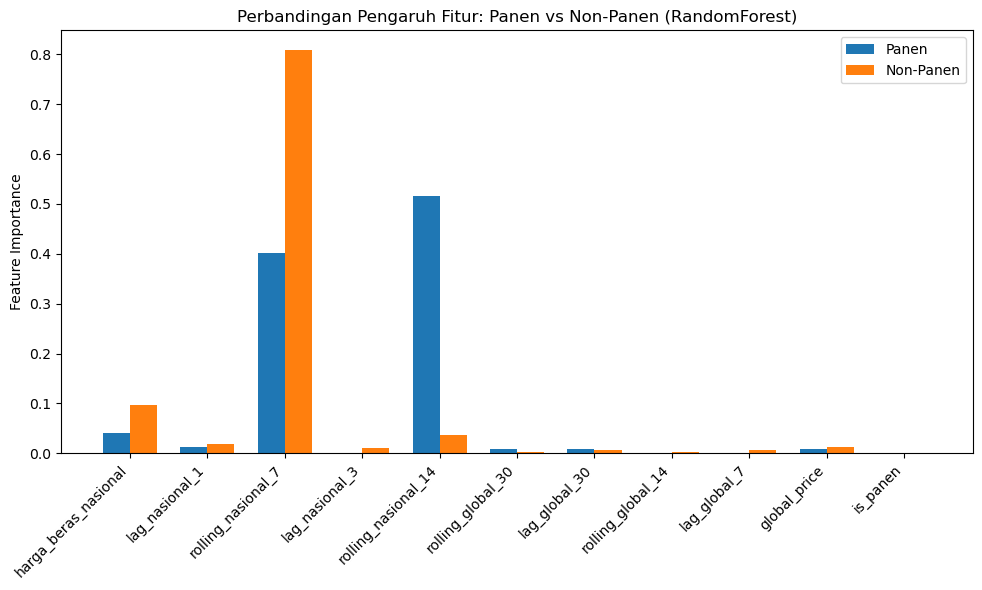

In [1]:
##########################################################################
### Explainable AI Time-based Feature Importance + RandomForest Tuning ###
##########################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ==========================
# 1. Load Dataset
# ==========================
df = pd.read_csv("CleanedDataset/Dataset_With_Features2.csv", parse_dates=["date"])

# Definisikan bulan panen (default Indonesia)
bulan_panen = [2, 3, 4, 8, 9, 10]  # Feb, Mar, Apr, Aug, Sep, Oct

# Tambahkan kolom kategori panen / nonpanen
df['is_panen'] = df['date'].dt.month.isin(bulan_panen).astype(int)

# Pisahkan fitur dan target
feature_cols = df.columns.drop(["date", "harga_beras_kateng"])
X = df[feature_cols]
y = df["harga_beras_kateng"]

# ==========================
# 2. Split Panen vs Non-Panen
# ==========================
X_panen = X[df['is_panen'] == 1]
y_panen = y[df['is_panen'] == 1]

X_nonpanen = X[df['is_panen'] == 0]
y_nonpanen = y[df['is_panen'] == 0]

# ==========================
# 3. Random Forest (Hasil Tuning Sebelumnya)
# ==========================
best_params = {'n_estimators': 107, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1}

rf_panen = RandomForestRegressor(**best_params, random_state=42)
rf_nonpanen = RandomForestRegressor(**best_params, random_state=42)

rf_panen.fit(X_panen, y_panen)
rf_nonpanen.fit(X_nonpanen, y_nonpanen)

# ==========================
# 4. Ambil Feature Importance
# ==========================
fi_panen = rf_panen.feature_importances_
fi_nonpanen = rf_nonpanen.feature_importances_

# ==========================
# 5. Plot Perbandingan
# ==========================
plt.figure(figsize=(10,6))
x = np.arange(len(feature_cols))
width = 0.35

plt.bar(x - width/2, fi_panen, width, label='Panen')
plt.bar(x + width/2, fi_nonpanen, width, label='Non-Panen')

plt.xticks(x, feature_cols, rotation=45, ha='right')
plt.ylabel("Feature Importance")
plt.title("Perbandingan Pengaruh Fitur: Panen vs Non-Panen (RandomForest)")
plt.legend()
plt.tight_layout()
plt.show()